In [1]:
import sqldb
import graph
import sqlite3
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import axes3d, Axes3D
from matplotlib import cm
from queue import SimpleQueue as Queue

In [2]:
db: sqlite3.Connection = sqldb.get_db_connection()
cities = np.array(sqldb.get_cities(db))
borders = np.array(sqldb.get_borders(db))

In [3]:
cities_map = {city[0]:city for city in cities}

In [4]:
print("Nb cities:", len(cities))
print("Nb borders:", len(borders))
print("Mean borders/cities:", len(borders)/len(cities))

Nb cities: 37525
Nb borders: 219294
Mean borders/cities: 5.843944037308461


In [5]:
ID_NAME = 1
ID_POPULATION = 4
THRESOLD = graph.Canton.BIG_THRESOLD
populations = np.array(cities[:,4], dtype=np.uint)
big_cities = cities[populations >= THRESOLD]

In [6]:
print("Nb big cities:", len(big_cities))
print("Mean borders/big cities:", len(borders)/len(big_cities))
print("Ratio:", len(big_cities)/len(cities) * 100)

Nb big cities: 119
Mean borders/big cities: 1842.8067226890757
Ratio: 0.31712191872085277


In [7]:
borders_map = dict()
for city in cities:
    borders_map.setdefault(city[0], []).append(city[0])
for border in borders:
    borders_map.setdefault(border[0], []).append(border[1])

{'whiskers': [<matplotlib.lines.Line2D at 0xf8b7350>,
 'caps': [<matplotlib.lines.Line2D at 0xf8b7950>,
 'boxes': [<matplotlib.lines.Line2D at 0xf8b7490>],
 'medians': [<matplotlib.lines.Line2D at 0xf8b7e10>],
 'fliers': [<matplotlib.lines.Line2D at 0xf8cc310>],
 'means': []}

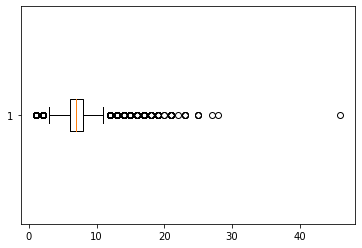

In [8]:
borders_map_count = [len(v) for v in borders_map.values()]
plt.boxplot(borders_map_count, vert=False)

In [9]:
queue = Queue()

for code in big_cities[:,0]:
    queue.put(code)

distances = {k:(0 if k in big_cities[:,0] else -1) for k in cities_map.keys()}

not_found = set()

while not queue.empty():
    city = queue.get()
    cur_dist = distances[city]
    for border_city in borders_map[city]:
        if not border_city in distances.keys():
            not_found.add(border_city)
            continue
        border_dist = distances[border_city]
        if border_dist == -1 or border_dist - cur_dist > 1:
            distances[border_city] = cur_dist + 1
            queue.put(border_city)

In [10]:
cities_map['Q28726684']

array(['Q28726684', 'Annecy', 'Q12751', 'Q18338206', '54145',
       '6.129444444', '45.899166666', '-1'], dtype='<U45')

In [11]:
cities[cities[:,0] == 'Q90']

array([], shape=(0, 8), dtype='<U45')

In [12]:
db.execute(''' SELECT * FROM cities where name = 'Q90'; ''').fetchall()

[]

In [13]:
print("Min dist:", min(distances.values()))
print("Max dist:", max(distances.values()))

Min dist: -1
Max dist: 22


In [14]:
missing = [code for code, dist in distances.items() if dist == -1]
missing_cities = [cities_map[code] for code in missing]

In [15]:
cities_map[missing[0]] # https://www.wikidata.org/wiki/Q216908 replaced by https://www.wikidata.org/wiki/Q21027256


array(['Q34797927', 'Cuisiat', 'Q42792', 'Q3769', '595', '5.3878561',
       '46.298968', '-1'], dtype='<U45')

In [16]:
cities_map['Q21027256']

array(['Q21027256', "Plœuc-L'Hermitage", 'Q3349', 'Q12130', '4088',
       '-2.756388888', '48.346944444', '-1'], dtype='<U45')

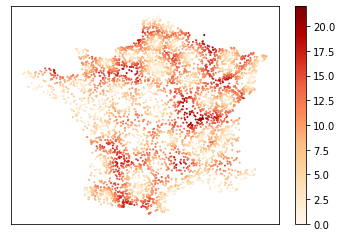

In [17]:
R = 6378.137
def convert3D(u):
    xyz = np.zeros((u.shape[0],3))
    u1 = u[:, 0] * (np.pi / 180)
    v1 = u[:, 1] * (np.pi / 180)
    xyz[:,2] = R * np.cos(u1) * np.sin(v1)
    xyz[:,1] = -R * np.cos(u1) * np.cos(v1)
    xyz[:,0] = R * np.sin(u1)
    return xyz

order = list(distances.keys())
coordinates = np.array([cities_map[o][5:7] for o in order if distances[o] != -1]).astype(np.float32)
dists = np.array([distances[o] for o in order if distances[o] != -1])
xyz = convert3D(coordinates)
dists = dists[xyz[:, 1] > -6000]
xyz = xyz[xyz[:, 1] > -6000]

# Only do it partially, it takes long for a full render
dists = dists[::8]
xyz = xyz[::8]

fig = plt.figure()
ax = fig.gca()
ax.set_yticks([])
ax.set_xticks([])
sc = ax.scatter(xyz[:, 0], xyz[:, 1], s=1, c=dists, cmap="OrRd")
plt.colorbar(sc)
plt.show()

In [39]:
# Updating DB with distances

dist_update = dict()
for code, dist in distances.items():
    dist_update.setdefault(dist, []).append(code)

# Updating rows by rows is so slow, so we use IN to edit rows by their distance. (all 1, then all2) etc
for dist, codes in dist_update.items():
    codes_str = "'"+"','".join(codes)+"'"
    db.execute(f"UPDATE cities SET distance = {dist} WHERE code IN({codes_str});")
db.commit()

In [20]:
import json

tmp_cities = db.execute("SELECT name, distance FROM cities").fetchall()
tmp_cities_map = {k[0]:k[1] for k in tmp_cities}

with open("firefox_addon/cities_data.json", mode="w", encoding='utf8') as f:
    json.dump(tmp_cities_map, f, ensure_ascii=False)

49.58425742574257
37.24959870463713


array(['rando', ' 41', '0', '42', '2', 'Ingra', 'Tilla'], dtype='<U5')

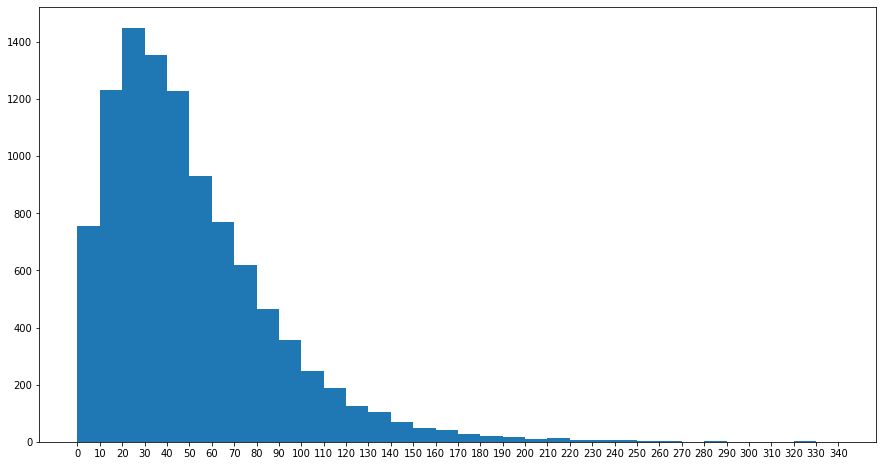

In [79]:
random = np.genfromtxt('randomstat.csv', delimiter=',', dtype="|U5")
random_jump = np.genfromtxt('randomstat.csv', delimiter=',', usecols=(1))
random_voyage = np.genfromtxt('randomstat.csv', delimiter=',', usecols=(3,4))

plt.figure(figsize=(15,8))
plt.hist(random_jump.astype(int), bins=(np.arange(0,350,10)))
plt.xticks(np.arange(0, 350,10))
print(np.mean(random_jump))
print(np.std(random_jump))
random[0]

(array([1.80871287, 0.19128713]),
 array([0. , 0.5, 1. ]),
 <a list of 2 Patch objects>)

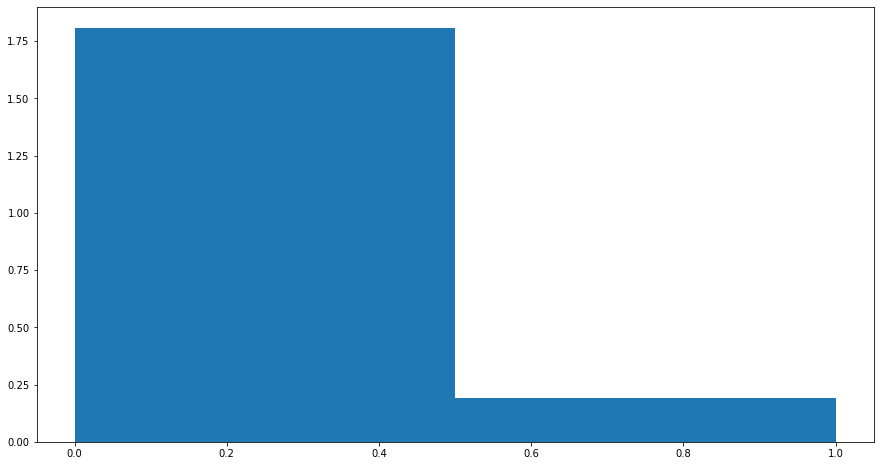

In [80]:
random = random[:,1:5].astype(int)

plt.figure(figsize=(15,8))
plt.hist(random[:,1], bins=(np.arange(0,1.1,0.5)), density=True)

0.09564356435643565


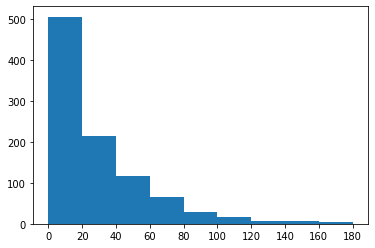

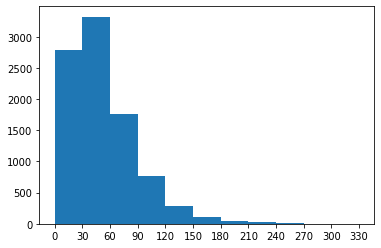

In [81]:
true_only = random[random[:,1] == 1]
false_only = random[random[:,1] == 0]
print(len(true_only)/len(random))

plt.hist(true_only[:,0],bins=(np.arange(0,200,20)))
plt.xticks(np.arange(0, 200,20))
plt.show()
plt.hist(false_only[:,0],bins=(np.arange(0,350,30)))
plt.xticks(np.arange(0, 350,30))
plt.show()

In [82]:
n = np.genfromtxt('followstat_north.csv', delimiter=',', usecols=(1,2,3,4) ,dtype=int)
ne = np.genfromtxt('followstat_nord-est.csv', delimiter=',', usecols=(1,2,3,4) ,dtype=int)
nw = np.genfromtxt('followstat_nord-ouest.csv', delimiter=',', usecols=(1,2,3,4) ,dtype=int)
se = np.genfromtxt('followstat_sud-est.csv', delimiter=',', usecols=(1,2,3,4) ,dtype=int)
sw = np.genfromtxt('followstat_sud-ouest.csv', delimiter=',', usecols=(1,2,3,4) ,dtype=int)
s = np.genfromtxt('followstat_sud.csv', delimiter=',', usecols=(1,2,3,4) ,dtype=int)
e = np.genfromtxt('followstat_est.csv', delimiter=',', usecols=(1,2,3,4) ,dtype=int)
w = np.genfromtxt('followstat_ouest.csv', delimiter=',', usecols=(1,2,3,4) ,dtype=int)


total = np.concatenate((n,ne,nw,se,sw,s,e,w,random), axis=0)
total.shape

(90575, 4)

54.38013800717637
[19. 43. 79.]
44.60648914128053
4.224554236820315


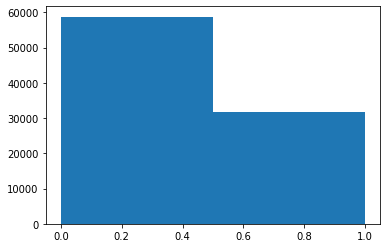

In [47]:
plt.hist([total[:,1]],bins=(0,0.5,1))
print(np.mean(total[:,0]))
print(np.quantile(total[:,0], [0.25, 0.5, 0.75]))
print(np.std(total[:,0]))
print(np.mean(total[:,-1]))

0.35144355506486336


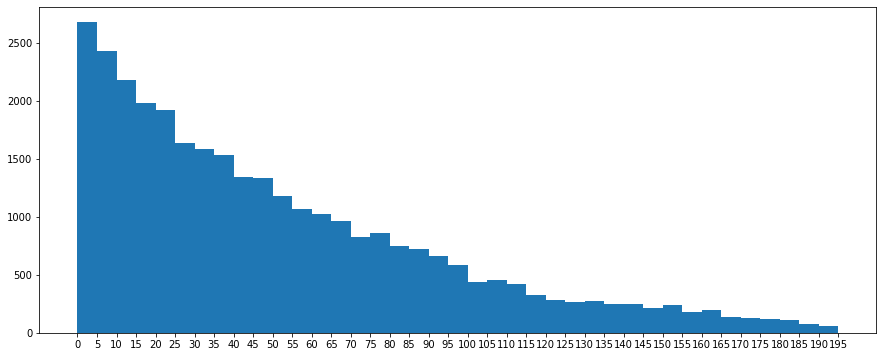

51.419357878864034
[16. 39. 76.]
44.39507220717539
4.609669514953506


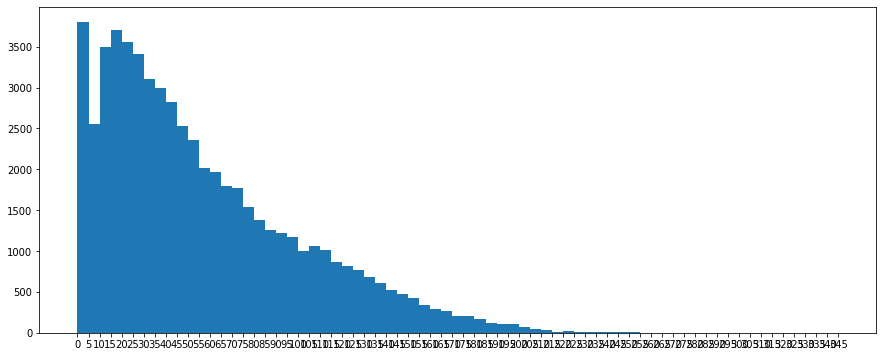

55.98454283914679
[21. 44. 82.]
44.63866966688218
4.015865720170914


In [72]:
true_only = total[total[:,1] == 1]
false_only = total[total[:,1] == 0]

print(len(true_only)/len(total))

plt.figure(figsize=(15,6))
plt.hist(true_only[:,0],bins=(np.arange(0,200,5)))
plt.xticks(np.arange(0, 200,5))
plt.show()
print(np.mean(true_only[:,0]))
print(np.quantile(true_only[:,0], [0.25, 0.5, 0.75]))
print(np.std(true_only[:,0]))
print(np.mean(true_only[:,-1]))

plt.figure(figsize=(15,6))
plt.hist(false_only[:,0],bins=(np.arange(0,350,5)))
plt.xticks(np.arange(0, 350,5))
plt.show()
print(np.mean(false_only[:,0]))
print(np.quantile(false_only[:,0], [0.25, 0.5, 0.75]))
print(np.std(false_only[:,0]))
print(np.mean(false_only[:,-1]))

In [83]:
print("% true: " ,sum(s[:,1])/len(s))
s_t = s[s[:,1] == 1]
print(np.mean(s[:,0]))
print(np.quantile(s[:,0], [0.25, 0.5, 0.75]))
print(np.std(s[:,0]))
print(np.mean(s[:,-1]))

print(np.mean(s_t[:,0]))
print(np.quantile(s_t[:,0], [0.25, 0.5, 0.75]))
print(np.std(s_t[:,0]))
print(np.mean(s_t[:,-1]))

% true:  0.5161
54.9102
[18. 42. 82.]
46.2032978905186
5.0336
59.91900794419686
[20. 46. 89.]
49.382837383459524
5.851191629529161


In [85]:
print("% true: " ,sum(se[:,1])/len(se))
se_t = se[se[:,1] == 1]
print(np.mean(se[:,0]))
print(np.quantile(se[:,0], [0.25, 0.5, 0.75]))
print(np.std(se[:,0]))
print(np.mean(se[:,-1]))

print(np.mean(se_t[:,0]))
print(np.quantile(se_t[:,0], [0.25, 0.5, 0.75]))
print(np.std(se_t[:,0]))
print(np.mean(se_t[:,-1]))

% true:  0.4145
51.3005
[18.   39.   73.25]
44.67995747256257
4.7964
42.59589867310012
[16. 37. 66.]
31.280720987457453
4.711700844390832


In [86]:
print("% true: " ,sum(sw[:,1])/len(sw))
sw_t = sw[sw[:,1] == 1]
print(np.mean(sw[:,0]))
print(np.quantile(sw[:,0], [0.25, 0.5, 0.75]))
print(np.std(sw[:,0]))
print(np.mean(sw[:,-1]))

print(np.mean(sw_t[:,0]))
print(np.quantile(sw_t[:,0], [0.25, 0.5, 0.75]))
print(np.std(sw_t[:,0]))
print(np.mean(sw_t[:,-1]))

% true:  0.4609
63.8558
[23. 51. 94.]
50.99118949740239
4.8261
66.09980472987633
[24. 54. 98.]
52.26723828814307
5.503796919071382


In [87]:
print("% true: " ,sum(nw[:,1])/len(nw))
nw_t = nw[nw[:,1] == 1]
print(np.mean(nw[:,0]))
print(np.quantile(nw[:,0], [0.25, 0.5, 0.75]))
print(np.std(nw[:,0]))
print(np.mean(nw[:,-1]))

print(np.mean(nw_t[:,0]))
print(np.quantile(nw_t[:,0], [0.25, 0.5, 0.75]))
print(np.std(nw_t[:,0]))
print(np.mean(nw_t[:,-1]))

% true:  0.4149
52.1445
[17. 39. 75.]
45.49263698391203
4.4584
57.70233791275006
[17. 44. 86.]
49.45227446076218
5.1925765244637265


In [88]:
print("% true: " ,sum(ne[:,1])/len(ne))
ne_t = ne[ne[:,1] == 1]
print(np.mean(ne[:,0]))
print(np.quantile(ne[:,0], [0.25, 0.5, 0.75]))
print(np.std(ne[:,0]))
print(np.mean(ne[:,-1]))

print(np.mean(ne_t[:,0]))
print(np.quantile(ne_t[:,0], [0.25, 0.5, 0.75]))
print(np.std(ne_t[:,0]))
print(np.mean(ne_t[:,-1]))

% true:  0.3734
65.0765
[23. 53. 97.]
50.963824893251484
4.3461
60.74799143010177
[22. 49. 91.]
47.19705315422084
4.29084092126406


In [90]:
print("% true: " ,sum(n[:,1])/len(n))
n_t = n[n[:,1] == 1]
print(np.mean(n[:,0]))
print(np.quantile(n[:,0], [0.25, 0.5, 0.75]))
print(np.std(n[:,0]))
print(np.mean(n[:,-1]))

print(np.mean(n_t[:,0]))
print(np.quantile(n_t[:,0], [0.25, 0.5, 0.75]))
print(np.std(n_t[:,0]))
print(np.mean(n_t[:,-1]))

% true:  0.2762723727627237
53.50714928507149
[19. 42. 80.]
43.48010029853214
4.488451154884512
45.97502714440825
[14.  34.  65.5]
41.10981769241027
4.544335866811437


In [91]:
print("% true: " ,sum(e[:,1])/len(e))
e_t = e[e[:,1] == 1]
print(np.mean(e[:,0]))
print(np.quantile(e[:,0], [0.25, 0.5, 0.75]))
print(np.std(e[:,0]))
print(np.mean(e[:,-1]))

print(np.mean(e_t[:,0]))
print(np.quantile(e_t[:,0], [0.25, 0.5, 0.75]))
print(np.std(e_t[:,0]))
print(np.mean(e_t[:,-1]))

% true:  0.3168798930685507
51.768760740882186
[18. 45. 80.]
38.27091045712579
4.247374451021577
40.965953600482074
[13. 34. 64.]
31.757001219744936
3.194034347695089


In [93]:
print("% true: " ,sum(w[:,1])/len(w))
w_t = w[w[:,1] == 1]
print(np.mean(w[:,0]))
print(np.quantile(w[:,0], [0.25, 0.5, 0.75]))
print(np.std(w[:,0]))
print(np.mean(w[:,-1]))

print(np.mean(w_t[:,0]))
print(np.quantile(w_t[:,0], [0.25, 0.5, 0.75]))
print(np.std(w_t[:,0]))
print(np.mean(w_t[:,-1]))
    

% true:  0.2986
47.4454
[17. 37. 70.]
38.725064478190355
4.0309
30.023107836570663
[11. 24. 45.]
22.74356452377048
3.1574012056262557
[1 0 1 ... 0 1 1]
